In [2]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import os,sys
import matplotlib.pyplot as plt
from gpytorch.kernels import RBFKernel,MaternKernel,ScaleKernel
from gpytorch.priors import GammaPrior
from gpytorch.likelihoods import GaussianLikelihood
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../code'))
if src_path not in sys.path:
    sys.path.append(src_path)
from gps import CholeskyGaussianProcess,IterativeGaussianProcess
from plotting import plot_gp_simple,plot_gp_sample
from util import train,eval,plot_gpr_results
%load_ext autoreload
%autoreload 2
# np.random.seed(42)
# torch.manual_seed(42)

device="cuda:0"
global_dtype=torch.float32


c:\Users\fredw\chris\Research\randomGP2\code\mbcg.py:58: SyntaxWarning: invalid escape sequence '\['
  """


In [3]:
# Define data generation function with an abstract true function
def generate_data(true_function, train_range=(-3, 3), test_range=(-3, 3), 
                  n_train=40, n_test=100, noise_std=0.1, 
                  device='cuda:0', dtype=torch.float64):
    # Generate training data
    X_train = torch.linspace(train_range[0], train_range[1], n_train, dtype=dtype, device=device).unsqueeze(-1)
    y_train = true_function(X_train) + noise_std * torch.randn_like(X_train)
    
    # Generate test data
    X_test = torch.linspace(test_range[0], test_range[1], n_test, dtype=dtype, device=device).unsqueeze(-1)
    y_test = true_function(X_test)  # No noise added to test data
    
    return X_train, y_train.squeeze(), X_test, y_test.squeeze()

# Define the true function
def true_function(x):
    
    return torch.sin(2 * x) + torch.cos(3 * x)

# Generate data using the true function
train_x, train_y, test_x, test_y = generate_data(true_function,train_range=(-3, 3), test_range=(-5,5), dtype=global_dtype)

 48%|████▊     | 24/50 [00:01<00:01, 22.43it/s]

Iter 20/50, Loss: -148.0738


 86%|████████▌ | 43/50 [00:01<00:00, 25.44it/s]

Iter 40/50, Loss: -449.8558


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


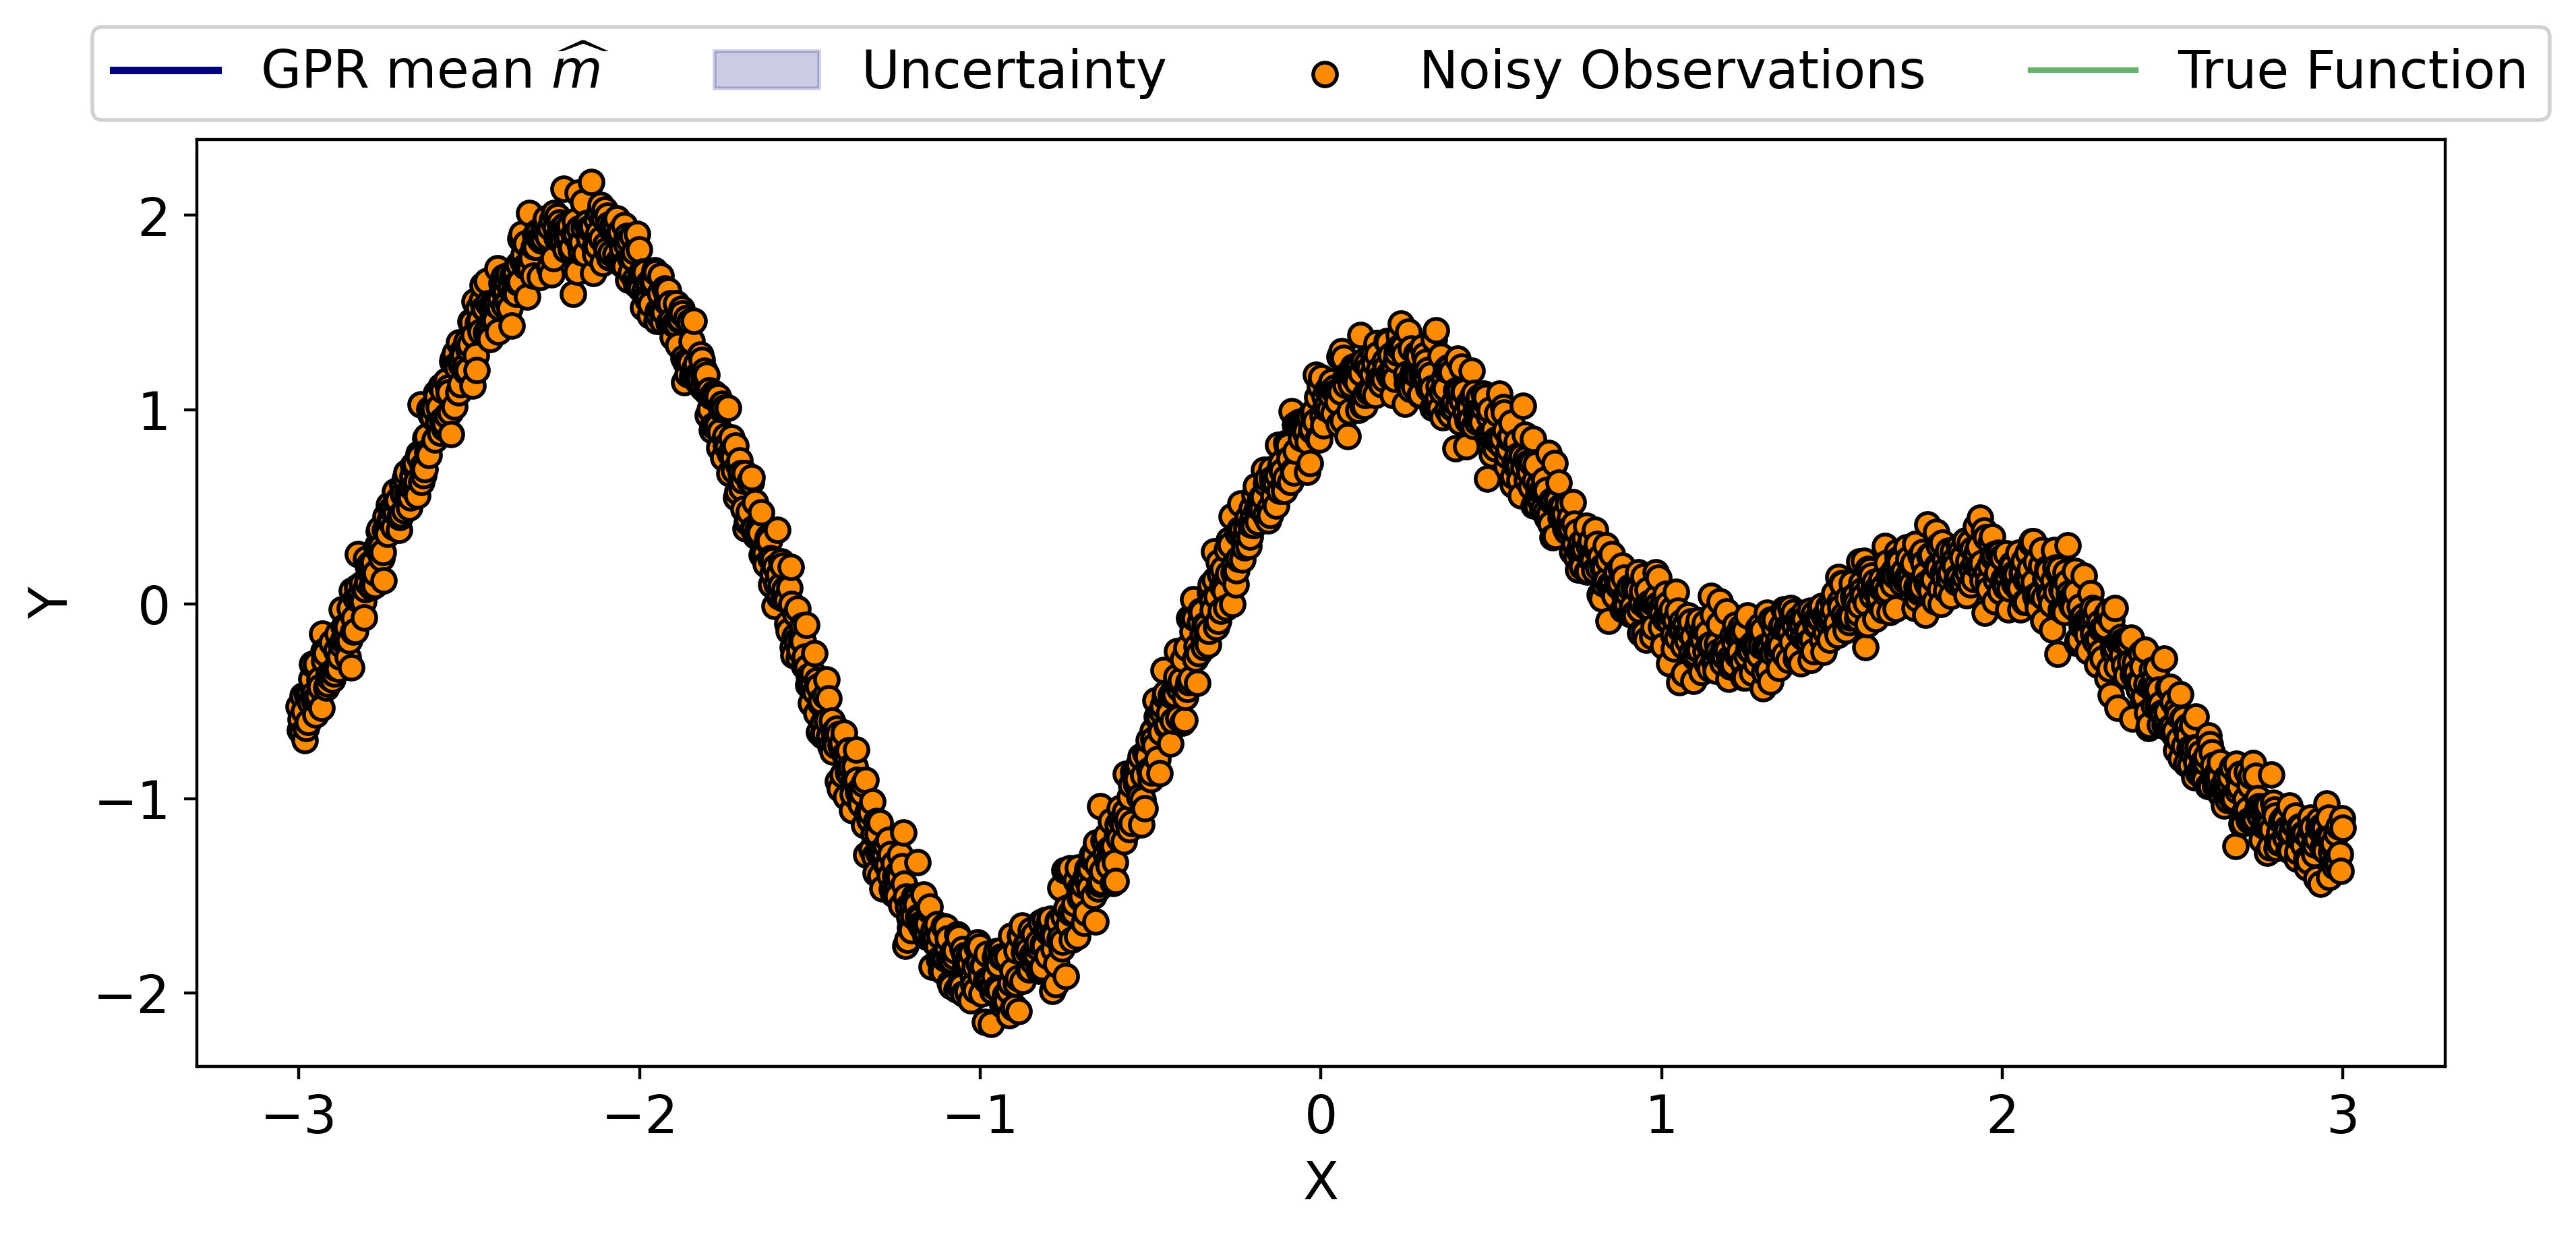

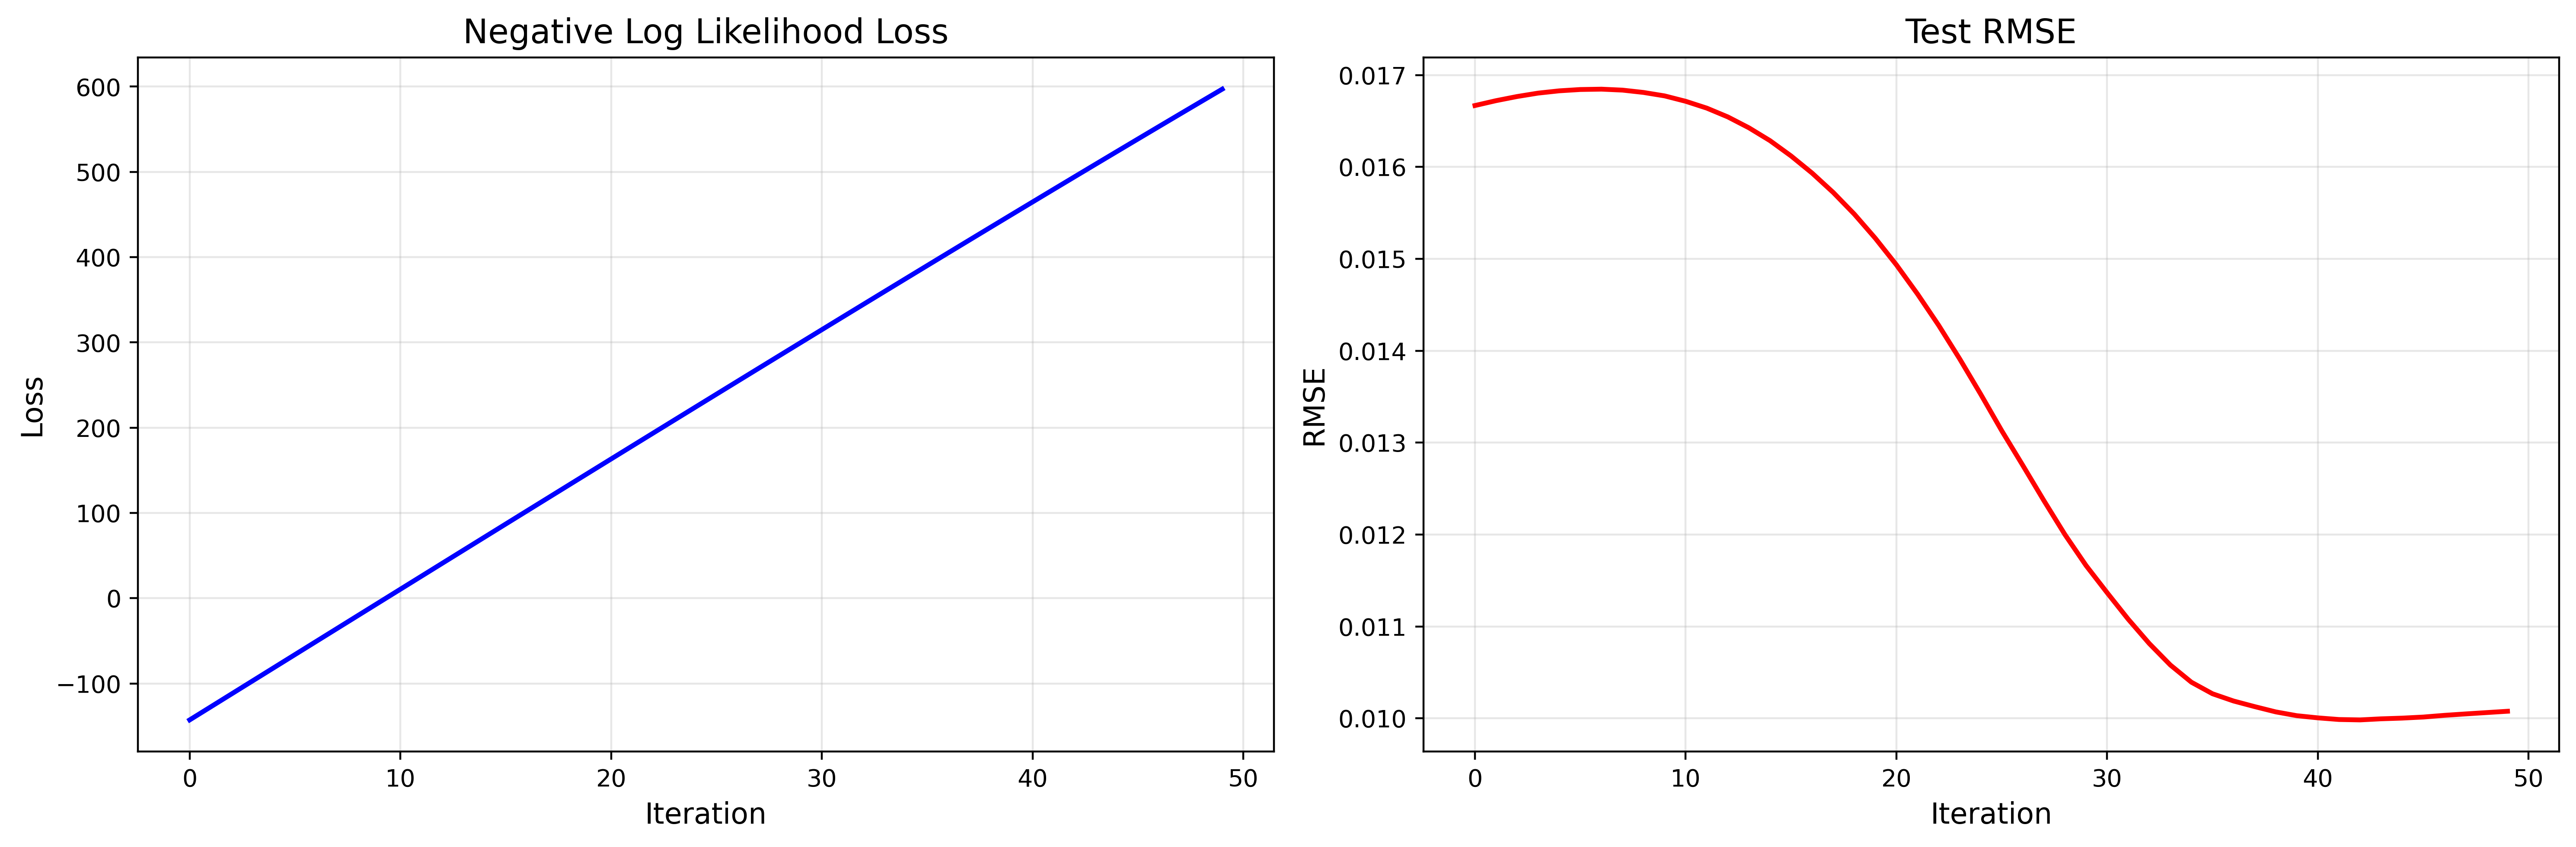

In [15]:

base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1] , lengthscale_prior=GammaPrior(-3.0, 3.0),nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(-3.0, 3)).to("cuda:0")
model = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=.4, device='cuda:0',compute_covariance=True)
training_iterations=50

from tqdm import tqdm
import time



def train(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):

    optimizer = torch.optim.Adam([
        {'params': model.kernel.parameters()}, 
        {'params': [model.noise.u]}  # Use raw_value instead of noise()
    ], lr=lr)
    runtime_log, mll_loss_log, test_rmse_log = [], [], []
    for i in tqdm(range(training_iterations)):
        start_time = time.time()
        optimizer.zero_grad()
        
        model.fit(train_x, train_y)
        loss = model.compute_mll(train_y)
        loss.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate

        # print(loss)
        mean, covar = model.predict(test_x)
        # mean = model.predict(test_x)

        total_time = time.time() - start_time
        runtime_log.append(total_time)
        mll_loss_log.append(-loss.item())
        
        test_rmse = (torch.mean(torch.abs(mean - test_y))).item()
        test_rmse_log.append(test_rmse)
        if (i + 1) % 20 == 0:
            print(f'Iter {i+1}/{training_iterations}, Loss: {loss.item():.4f}')
    
    return model, runtime_log, mll_loss_log, test_rmse_log, mean, covar
train_x, train_y, test_x, test_y = generate_data(true_function,train_range=(-3, 3), test_range=(-3,3),n_train=2000, dtype=global_dtype)

model, runtime_log, mll_loss_log, test_rmse_log, mean, covar = train(model, train_x, train_y, test_x, test_y, training_iterations,lr=.01)
std = torch.sqrt(torch.diag(covar))

# model, runtime_log, mll_loss_log, test_rmse_log, mean = train(model, train_x, train_y, test_x, test_y, training_iterations,lr=.01)
# std=0
plot_gpr_results(
    train_x=train_x,
    train_y=train_y,
    test_x=test_x,
    test_y=test_y,
    GP_mean=mean,
    std=std,
    mll_loss_log=mll_loss_log,
    test_rmse_log=test_rmse_log
)

Training Iterative Gaussian Process (IGP)


 40%|████      | 20/50 [00:11<00:19,  1.56it/s]

Iter 20/50, Loss: -140.0137


 80%|████████  | 40/50 [00:26<00:07,  1.36it/s]

Iter 40/50, Loss: -429.0072


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]



Training Cholesky Gaussian Process (CGP)


 46%|████▌     | 23/50 [00:01<00:01, 25.31it/s]

Iter 20/50, Loss: -148.0738


 88%|████████▊ | 44/50 [00:01<00:00, 27.41it/s]

Iter 40/50, Loss: -449.8558


100%|██████████| 50/50 [00:01<00:00, 25.11it/s]


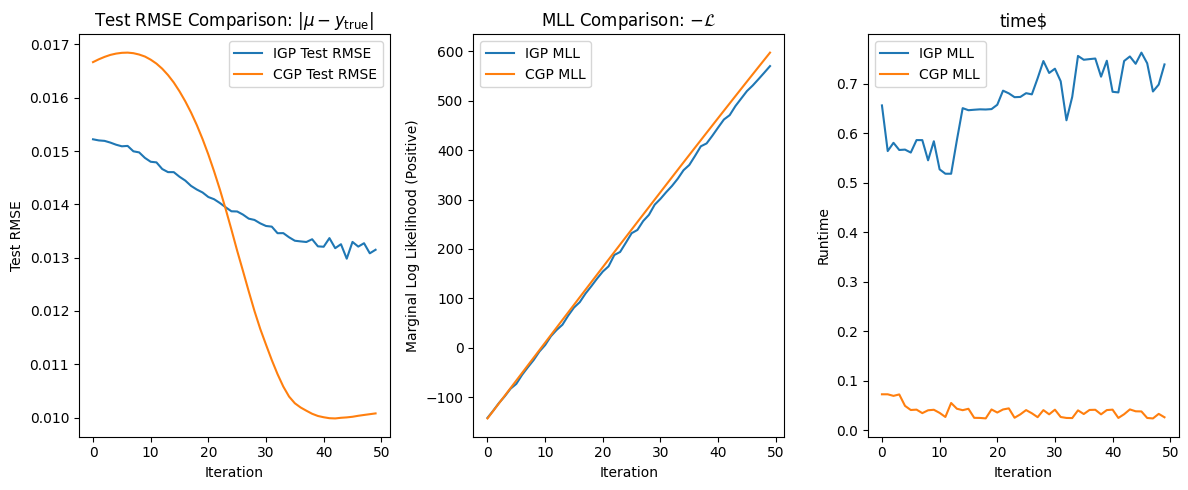

AttributeError: 'int' object has no attribute 'detach'

In [19]:
# train_x, train_y, test_x, test_y = generate_data(true_function,train_range=(-3, 3), test_range=(-5,5), dtype=global_dtype,n_train=1000)
# ----------------------------
# Initialize the Iterative GP
# ----------------------------
base_kernel_igp = MaternKernel(ard_num_dims=train_x.shape[-1], 
                               lengthscale_prior=GammaPrior(-3.0, 3.0), 
                               nu=1.5)
kernel_igp = ScaleKernel(base_kernel_igp, outputscale_prior=GammaPrior(-3.0, 3)).to("cuda:0")
igp_model = IterativeGaussianProcess(kernel=kernel_igp, noise=0.4, dtype=global_dtype, device=device,
                                     cg_tol=1e-3, cg_max_iter=20, warm_start=False, num_probes=16,
                                     precon_type="piv_chol", trace_backend="Hutch",
                                     verbose=False, track_iterations=True, 
                                     pred_lanczos_rank=train_x.shape[0],compute_covariance=False)

# ----------------------------
# Initialize the Cholesky GP
# ----------------------------
base_kernel_cgp = MaternKernel(ard_num_dims=train_x.shape[-1], 
                               lengthscale_prior=GammaPrior(-3.0, 3.0), 
                               nu=1.5)
kernel_cgp = ScaleKernel(base_kernel_cgp, outputscale_prior=GammaPrior(-3.0, 3)).to("cuda:0")
cgp_model = CholeskyGaussianProcess(kernel=kernel_cgp, dtype=global_dtype, noise=0.4, device="cuda:0")

training_iterations = 50
lr = 0.01

print("Training Iterative Gaussian Process (IGP)")
igp_model, runtime_log_igp, mll_loss_log_igp, test_rmse_log_igp, mean_igp, covar_igp = \
    train(igp_model, train_x, train_y, test_x, test_y, training_iterations, lr)

print("\nTraining Cholesky Gaussian Process (CGP)")
cgp_model, runtime_log_cgp, mll_loss_log_cgp, test_rmse_log_cgp, mean_cgp, covar_cgp = \
    train(cgp_model, train_x, train_y, test_x, test_y, training_iterations, lr)

# ----------------------------
# Two-Panel Plot: RMSE and MLL
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot RMSE comparison
axes[0].plot(test_rmse_log_igp, label="IGP Test RMSE")
axes[0].plot(test_rmse_log_cgp, label="CGP Test RMSE")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Test RMSE")
axes[0].set_title(r"Test RMSE Comparison: $|\mu - y_{\text{true}}|$")
axes[0].legend()

# Plot MLL comparison
axes[1].plot(mll_loss_log_igp, label="IGP MLL")
axes[1].plot(mll_loss_log_cgp, label="CGP MLL")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Marginal Log Likelihood (Positive)")
axes[1].set_title(r"MLL Comparison: $-\mathcal{L}$")
axes[1].legend()


# Plot MLL comparison
axes[2].plot(runtime_log_igp, label="IGP MLL")
axes[2].plot(runtime_log_cgp, label="CGP MLL")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Runtime")
axes[2].set_title(r"time$")
axes[2].legend()
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# ----------------------------
# Optionally, Plot GP Predictions
# ----------------------------
# std_igp = torch.sqrt(torch.diag(covar_igp))
std_igp = 0

std_cgp = torch.sqrt(torch.diag(covar_cgp))

plot_gpr_results(
    train_x=train_x,
    train_y=train_y,
    test_x=test_x,
    test_y=test_y,
    GP_mean=mean_igp,
    std=std_igp,
    mll_loss_log=mll_loss_log_igp,
    test_rmse_log=test_rmse_log_igp,
)

plot_gpr_results(
    train_x=train_x,
    train_y=train_y,
    test_x=test_x,
    test_y=test_y,
    GP_mean=mean_cgp,
    std=std_cgp,
    mll_loss_log=mll_loss_log_cgp,
    test_rmse_log=test_rmse_log_cgp,
)


In [55]:
import torch
import matplotlib.pyplot as plt
from line_profiler import LineProfiler
def train2(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):

    optimizer = torch.optim.Adam([
        {'params': model.kernel.parameters()}, 
        {'params': [model.noise.u]}  # Use raw_value instead of noise()
    ], lr=lr)
    runtime_log, mll_loss_log, test_rmse_log = [], [], []
    for i in tqdm(range(training_iterations)):
        start_time = time.time()
        optimizer.zero_grad()
        
        model.fit(train_x, train_y)
        loss = model.compute_mll(train_y)
        loss.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate

        # print(loss)
        mean = model.predict(test_x)
        total_time = time.time() - start_time
        runtime_log.append(total_time)
        mll_loss_log.append(-loss.item())
        
        test_rmse = (torch.mean(torch.abs(mean - test_y))).item()
        test_rmse_log.append(test_rmse)
        if (i + 1) % 20 == 0:
            print(f'Iter {i+1}/{training_iterations}, Loss: {loss.item():.4f}')
    
    return model, runtime_log, mll_loss_log, test_rmse_log, mean, covar


def run_igp_training():
    # Set up the base and scaled kernel for the IGP
    base_kernel_igp = MaternKernel(ard_num_dims=train_x.shape[-1], 
                                   lengthscale_prior=GammaPrior(-3.0, 3.0), 
                                   nu=1.5)
    kernel_igp = ScaleKernel(base_kernel_igp, outputscale_prior=GammaPrior(-3.0, 3)).to("cuda:0")
    
    # Initialize the Iterative Gaussian Process model with the desired parameters
    igp_model = IterativeGaussianProcess(
        kernel=kernel_igp, 
        noise=0.4, 
        dtype=global_dtype, 
        device=device,
        cg_tol=1e-3, 
        cg_max_iter=20, 
        warm_start=True, 
        num_probes=16,
        precon_type="piv_chol", 
        trace_backend="Hutch",
        verbose=False, 
        track_iterations=True, 
        pred_lanczos_rank=train_x.shape[0],
        compute_covariance=False
    )
    
    training_iterations = 1
    lr = 0.01

    print("Training Iterative Gaussian Process (IGP)")
    # Train the IGP model and capture relevant outputs2
    results = train2(igp_model, train_x, train_y, test_x, test_y, training_iterations, lr)
    return results

# Set up the line profiler
lp = LineProfiler()
from mbcg import take_cg_step
# Add the main training function and key IGP class methods you want to profile.
# Here we add the train function, and as an example, the forward method of IterativeGaussianProcess.
lp.add_function(train2)
lp.add_function(take_cg_step)

lp.add_function(IterativeGaussianProcess.forward)
lp.add_function(IterativeGaussianProcess.fit)

# If there are other important methods (for example, an 'optimize' method), add them similarly:
# lp.add_function(IterativeGaussianProcess.optimize)

# Wrap the IGP training run with the profiler and execute it.
lp_wrapper = lp(run_igp_training)
results = lp_wrapper()

# Print out the profiling statistics.
lp.print_stats()

Training Iterative Gaussian Process (IGP)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

Timer unit: 1e-07 s

Total time: 0.810546 s
File: C:\Users\fredw\AppData\Local\Temp\ipykernel_31636\1219501532.py
Function: train2 at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def train2(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):
     5                                           
     6         3       2188.0    729.3      0.0      optimizer = torch.optim.Adam([
     7         1         67.0     67.0      0.0          {'params': model.kernel.parameters()}, 
     8         1         70.0     70.0      0.0          {'params': [model.noise.u]}  # Use raw_value instead of noise()
     9         1          3.0      3.0      0.0      ], lr=lr)
    10         1          5.0      5.0      0.0      runtime_log, mll_loss_log, test_rmse_log = [], [], []
    11         2      29964.0  14982.0      0.4      for i in tqdm(range(training_iterations)):
    12         1          9.0      9.0    